In [1]:
%load_ext autoreload
%autoreload 2

# Can U-Net predict only the evidence?

What exactly _is_ the evidence in the Skyline12 dataset anyways?

It's actually _scribbles_ that _roughly_ indicate the position of building on the image. There is an individual scribble (points that form a path of a brush stroke) for each building. In our case, to make them usable we create white brush stroke (of a set stroke size) on a black canvas of the same dimensions as each corresponding image. So the evidence is actually an image with black and white pixels.

In [2]:
!mkdir -p /tmp/ds_cache/
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('/storage/skyline12/data/')

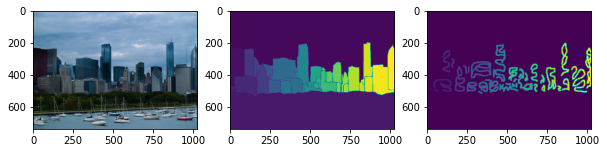

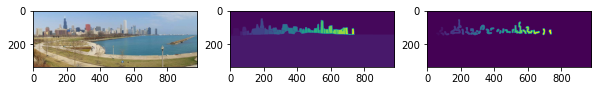

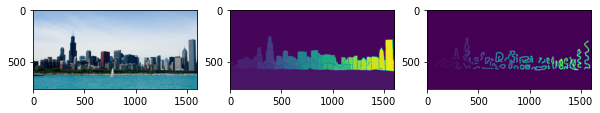

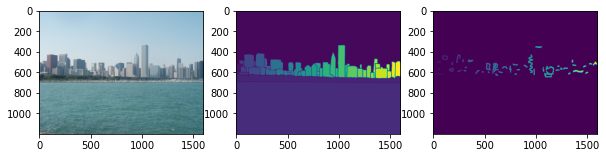

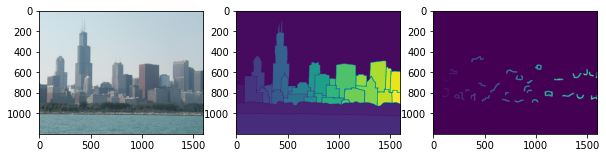

In [3]:
from itertools import islice

for x, y, z in islice(skyline12, 5):
    Skyline12.show_sample(x, [y, z])

As we can see from the small preview of the dataset (ignoring the different colormapping), the scribbles are really sparse. This is expected, as the buildings, at least in the original untampered dataset, take up only a portion of the image. Even so, the density of the drawings vary significantly.

In [4]:
# measuring the class balance
import numpy as np


def get_class_ratio(img):
    img = np.ravel(img)
    pos = img[img > 0]
    neg = img[img == 0]
    return 100 * len(pos) / (len(pos) + len(neg))


class_ratios = np.array([get_class_ratio(z) for _, _, z in skyline12])

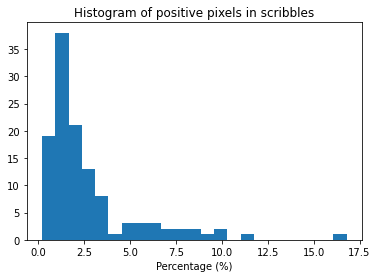

In [5]:
import matplotlib.pyplot as plt

plt.hist(class_ratios, 'auto')
plt.title('Histogram of positive pixels in scribbles')
plt.xlabel('Percentage (%)');

We see that in most of the images in the original Skyline12 dataset, scribbles are less than 2% of the total pixels. That makes it a problem of _class imbalance_ that we need to deal with if we want the model to train fast enough and not spend a number of epochs just to learn to ignore the 0-value pixels. Even worse, it _could_ get trapped in a local minimum, depeding of the loss function and activation that we choose.

## Training with default settings

In [6]:
from models.unet import create_unet

ds = skyline12.as_tf_dataset(folds=1).map(lambda x, y, z: (x, z))

unet = create_unet(num_classes=1, output_activation='sigmoid')
unet.compile(loss='binary_crossentropy', optimizer='adam')
history = unet.fit(ds.batch(4).cache(), epochs=20)

Epoch 1/20
      2/Unknown - 1s 285ms/step - loss: 2.5153WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1877s vs `on_train_batch_end` time: 0.3750s). Check your callbacks.
30/30 [==============================] - 55s 2s/step - loss: 0.3884
Epoch 2/20
30/30 [==============================] - 17s 556ms/step - loss: 0.2028
Epoch 3/20
30/30 [==============================] - 17s 555ms/step - loss: 0.1958
Epoch 4/20
30/30 [==============================] - 17s 555ms/step - loss: 0.1926
Epoch 5/20
30/30 [==============================] - 17s 557ms/step - loss: 0.1907
Epoch 6/20
30/30 [==============================] - 17s 557ms/step - loss: 0.1896
Epoch 7/20
30/30 [==============================] - 17s 556ms/step - loss: 0.1887
Epoch 8/20
30/30 [==============================] - 17s 557ms/step - loss: 0.1971
Epoch 9/20
30/30 [==============================] - 17s 557ms/step - loss: 0.1906
Epoch 10/20
30/30 [=========================

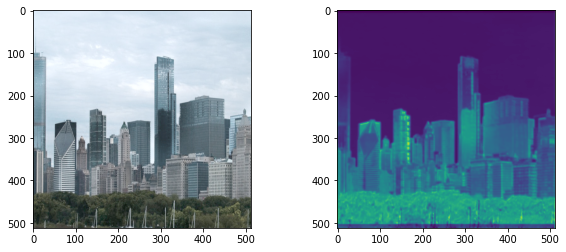

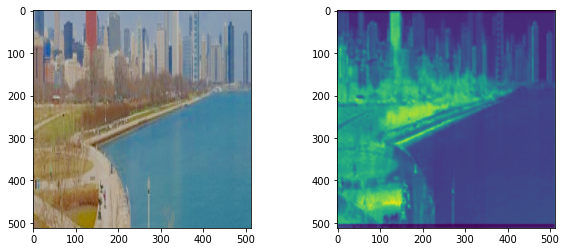

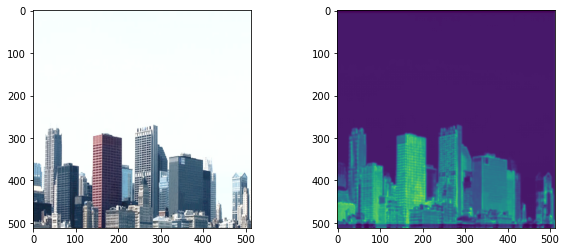

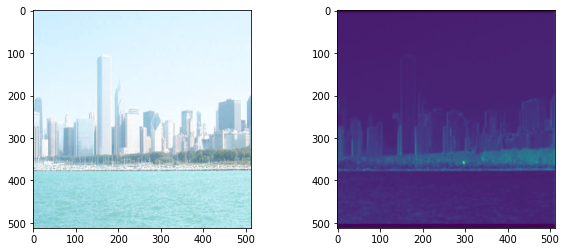

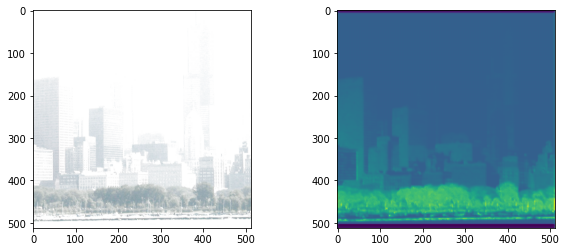

In [7]:
for x, _ in islice(ds.batch(1), 5):
    preds = unet(x, training=False)
    Skyline12.show_sample(x[0], [preds[0]], from_tensors=True)

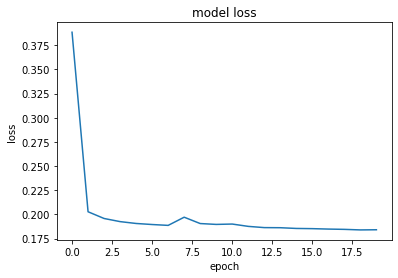

In [8]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    

plot_history(history)

With the model seemignly converging, the predictions are nothing close to the scribbles.

Let's try on a bigger version of the (augmented) dataset